In [219]:
import os
import numpy as np
import numpy.random as rand
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import cv2 as cv
import scipy.ndimage as nimg
import pandas as pd
import skimage as si
import seaborn as sns
# from picamera import PiCamera
# from picamera.array import PiRGBArray
from sklearn import metrics
from matplotlib import patches
from scipy import optimize as opt, special as spec
from tqdm.notebook import tqdm_notebook as tqdm, tnrange
from jupyterthemes import jtplot

In [175]:
%matplotlib inline
jtplot.reset()
sns.set()
sns.set_context('paper')
plt.rcParams["axes.axisbelow"] = True
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

## PiCam end

In [ ]:
camera = PiCamera()

In [15]:
camera.resolution = (1920, 1080)
camera.framerate = 15
camera.iso = 400
camera.shutter_speed = int(1/15 * 1e6)
rawCapture = PiRGBArray(camera, size=camera.resolution)
time.sleep(0.2)
for frame in camera.capture_continuous(rawCapture, format='bgr', use_video_port=True):
    image = frame.array
    cv.imshow('image', image)
    key = cv.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    
    if key == ord('s'):
        cv.imwrite('double-0.04-0.50.png', image)
    if key == ord('q'):
        break
cv.destroyAllWindows()

In [35]:
cap = cv.VideoCapture('darkframe-iso800-30fps.h264')
count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        if count == 0:
            dark = np.zeros_like(frame, float)
        if count >= 200:
            dark += frame
        count += 1
    else:
        break
dark /= 250
dark /= dark.max()
dark *= 255
dark = np.uint8(dark)
cap.release()
cv.imwrite('darkframe-iso800-30fps.png', dark)

True

## Computer end

In [243]:
class ApertureEstimator:
    def __init__(self, diff_pattern, dark_frame=None):
        """
        This class takes an a diffraction pattern image as its input
        and estimates the aperture that caused it.

        Parameters
        ----------
        diff_pattern : str or array
            The filename of the image, or an existing numpy array 
            containing the image.
        dark_frame : str or array, optional
            Filename or array of a reference dark frame to subtract 
            from the diffraction image.
        """
        if dark_frame is not None:
            self.dark_frame = self._parse_input_images(dark_frame)
        self.diff_pattern = self._parse_input_images(diff_pattern)
        if dark_frame is not None:
            if self.dark_frame.shape != self.diff_pattern.shape:
                self.dark_frame = cv.resize(self.dark_frame, 
                                     self.diff_pattern.shape[::-1])
            self.diff_pattern -= self.dark_frame
        
        self.parameter_names = ['max_intensity', 
                                'frequency', 
                                'bias', 
                                'phase']

    def _parse_input_images(self, parsee):
        """
        A convenience function for handling data input.

        Parameters
        ----------
        parsee : str or array
            If str, assumes a filename and reads from the directory. 
            If array, makes a copy of the array.

        Returns
        -------
        out : array
            Returns array of image converted to grayscale.
        """
        if isinstance(parsee, str):
            self.filename = parsee
            return cv.imread(parsee, 0)
        elif isinstance(parsee, np.ndarray):
            return parsee
        else:
            raise TypeError('Input must be a filename or numpy array.')
            
    def showPattern(self, savename=None):
        """
        Displays the grayscale diffraction pattern image.

        Parameters
        ----------
        savename : str, optional
            Name of the file to save the figure to. Automatically 
            saves if value is set to anything other than `None`.
        """
        plt.imshow(self.diff_pattern, 'gray')
        plt.grid(0)
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        
    def estimateAperture(self, 
                         logscale=False, 
                         logbase=10, 
                         hold='off', 
                         savename=None):
        """
        Preliminary estimation of the aperture by performing a forward
        Fourier transform.

        Parameters
        ----------
        logscale : bool
            Whether to display the Fourier transform in log scale.
        logbase : int
            Base of the logarithm to be used. Defaults to base 10.
        hold : str
            Similar to MATLAB's hold function. If `off`, displays the 
            figure immediately. If `on`, does not display until 
            plt.show() is called explicity. Useful when further 
            changes to the figure are needed.
        savename : str
            Name of the file to save the figure to. Automatically 
            saves if value is set to anything other than `None`.
        """
        self.aperture = fft.fft2(self.diff_pattern)
        if logscale:
            if logbase == 10:
                log = np.log10
            elif logbase == 2:
                log = np.log2
            elif logbase == 'e':
                log = np.log
            else:
                raise ValueError('base must be 2, 10, or `e`')
            self.aperture_display = abs(log(fft.fftshift(
                                        self.aperture)))
            plt.imshow(self.aperture_display, 'gray')
        else:
            self.aperture_display = abs(fft.fftshift(self.aperture))
            plt.imshow(self.aperture_display, 'gray')
        plt.grid(0)
#         plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()
            
    def diffractionFitter(self, threshold=200, complex_break=None):
        """
        Better estimation of the aperture using blob analysis.

        Parameters
        ----------
        threshold : int
            Due to the noise present in the Fourier domain when 
            capturing using the PiCam, automatic thresholding 
            algorithms do not work, and the threshold must be set 
            manually. A good starting point is around 170-200.

        Examples
        --------
        Useful threshold values for the recorded images:
            single-0.08 threshold = 205
            single-0.16 threshold = 183
            double-0.04-0.25 threshold = 180
            double-0.08-0.25 threshold = 165
            double-0.08-0.50 threshold = 155
        """

        A = self.aperture_display
        h, w = self.diff_pattern.shape
        
        # Normalize image and convert to uint8
        A = ((A - A.min())/(A.max() - A.min()) * 255).astype('uint8')
        thres, out = cv.threshold(A, threshold, 255, cv.THRESH_BINARY)
        
        # Detect blobs, obtain their regionprops and store their 
        # attributes in a dataframe
        blob = si.measure.label(out)
        props = si.measure.regionprops(blob, coordinates='xy')
        num_props = len(props)
        prop_names = pd.Series(props[0])
        prop_vals = np.zeros((len(prop_names), num_props), object)
        for i in range(len(prop_names)):
            for j in range(num_props):
                prop_vals[i,j] = props[j][prop_names[i]]
        props_df = pd.DataFrame(data=prop_vals.T, columns=prop_names)

        # Sort labeled regions by decreasing area. We assume that 
        # since the DC bias and the surrounding area has the highest 
        # intensity, it will also have the largest detected area. 
        # In the case of a double slit, 3 or more regions may be 
        # detected, but it is highly likely that the peaks caused
        # by the double slit have the next-largest area.
        props_df = props_df.sort_values(by=['bbox_area'], 
                                        ascending=False)
        slit_len = props_df['major_axis_length'].values
        slit_wid = props_df['minor_axis_length'].values
        slit_center = props_df['centroid'].values

        # All labeled regions will have major-axis, minor-axis 
        # and centroid properties. We can use these to estimate the 
        # slit length, slit width, and slit center, respectively.
        if 'pinhole' in self.filename:
            hh = np.arange(h)
            ww = np.arange(w)
            Ma = slit_len[0]
            ma = slit_wid[0]
            X, Y = np.meshgrid(ww, hh)
            cy, cx = np.int_(slit_center[0])
            L = np.int_((((X - cx)/Ma)**2 \
                         + ((Y - cy)/ma)**2 <= 1)*255)
        else:
            L = np.zeros((h, w))
            for i in range(len(slit_len)):
                if len(slit_len) >= 3:
                    if 'double' in self.filename:
                        if i == 0:
                            continue
                        if i == 3:
                            break
                    elif 'single' not in self.filename and \
                         'double' not in self.filename:
                        if i == 0:
                            continue
                        if complex_break is not None and \
                           i == complex_break:
                            break
                if 'single' in self.filename:
                    if i == 1:
                        break
                cy, cx = np.int_(slit_center[i])
                sl = np.int_(slit_len[i])
                sw = np.int_(slit_wid[i])
                L[cy-sl//2:cy+sl//2+1, cx-sw//2:cx+sw//2+1] = 1
        blob_ft = abs(fft.fftshift(fft.fft2(L)))
        
        self.region_props = props_df
        self.aperture_blob = L
        self.diff_blob = blob_ft
        self.blob = blob
        
    def showFit(self, r=64, zoom=True, aspect='auto', savename=None):
        """
        Convenience function to plot and compare the experimental 
        and estimated apertures and diffraction patterns.

        Parameters
        ----------
        r : int
            Length of the viewing window when zoom is `True`.
        zoom : bool
            Whether to zoom into the center of the Fourier spectrum.
        aspect : str
            See plt.imshow() reference guide.
        savename : str
            Name of the file to save the figure to. Automatically 
            saves ifvalue is set to anything other than `None`.
        """
        h, w = self.diff_pattern.shape
        plt.figure(figsize=(5*1.25, 5*1.25))
        
        plt.subplot(221)
        plt.imshow(self.diff_pattern, 'gray', aspect=aspect)
        plt.grid(0)
        plt.title('experimental diffraction')
        plt.axis('off')
        
        plt.subplot(222)
        plt.imshow(self.aperture_display, 'gray', aspect=aspect)
        plt.grid(0)
        plt.axis('off')
        plt.title('experimental aperture')
        plt.xlim(w//2-r, w//2+r)
        plt.ylim(h//2-r, h//2+r)
        
        plt.subplot(223)
        plt.imshow(self.diff_blob, 'gray', aspect=aspect)
        plt.title('estimated diffraction')
        plt.grid(0)
        plt.axis('off')
        
        plt.subplot(224)
        plt.imshow(self.aperture_blob, 'gray', aspect=aspect)
        plt.title('estimated aperture')
        plt.grid(0)
        plt.axis('off')
        
        if zoom:
            plt.xlim(w//2-r, w//2+r)
            plt.ylim(h//2-r, h//2+r)
        
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()
        
    def _singleslit_intensity(self, x, I0, a, b, phi):
        return I0 * spec.spherical_jn(0, np.pi*a*x - phi)**2 + b
    
    def _doubleslit_intensity(self, x, I0, d, b, phi):
        return I0 * np.cos(d*x - phi)**2 + b
    
    def _circle_intensity(self, x, I0, a, b, phi):
        return I0 * (2 * spec.jn(1, (a*x - phi))/(a*x - phi))**2 + b

    def _metric_handler(self, y_true, y_pred):
        if self.metric == 'mse':
            met = metrics.mean_squared_error(y_true, y_pred)
        elif self.metric == 'rmse':
            met = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
        else:
            raise NotImplementedError
        return met
    
    def _optimizer_handler(self, 
                           ptype, 
                           x, y, 
                           sf,
                           lower_bounds=-np.inf, 
                           upper_bounds=np.inf, 
                           offset=None, 
                           crops=None):
        if ptype == 'single':
            popt, pcov = opt.curve_fit(self._singleslit_intensity, 
                                       x*sf, y, 
                                       bounds=([0, 0, 0, -np.pi], 
                                               [np.inf, np.inf, 
                                                np.inf, np.pi]))
            yopt = self._singleslit_intensity(x*sf, *popt)
            yopt /= (yopt.max())
            met = self._metric_handler(y, yopt)
            popt = dict(zip(self.parameter_names, popt))
            return yopt, met, popt, pcov
        elif ptype == 'double':
            spopt, spcov = opt.curve_fit(self._singleslit_intensity, 
                                         x*sf, y, bounds=(0, np.inf))
            dpopt, dpcov = opt.curve_fit(self._doubleslit_intensity, 
                                         ((x + offset)[crops] \
                                          - offset)*sf, y[crops],
                                         bounds=(lower_bounds, 
                                                 upper_bounds))
            ys = self._singleslit_intensity(x*sf, *spopt)
            yd = self._doubleslit_intensity(x*sf, *dpopt)
            yopt = ys*yd
            yopt /= yopt.max()
            met = self._metric_handler(y, yopt)
            spopt = dict(zip(self.parameter_names, spopt))
            dpopt = dict(zip(self.parameter_names, dpopt))
            return yopt, met, [spopt, dpopt], [spcov, dpcov]
        elif ptype == 'pinhole':
            popt, pcov = opt.curve_fit(self._circle_intensity, 
                                       x*sf, y,
                                       p0=0.5*np.ones(4),
                                       bounds=([0, 0, 0, -np.pi], 
                                               [np.inf, np.inf, 
                                                np.inf, np.pi]))
            yopt = self._circle_intensity(x*sf, *popt)
            yopt /= (yopt.max())
            met = self._metric_handler(y, yopt)
            popt = dict(zip(self.parameter_names, popt))
            return yopt, met, popt, pcov
        else:
            raise NotImplementedError
            
    def fitProfile(self, ptype, metric='rmse', 
                   hold='off', savename=None):
        self.metric = metric
        plt.figure(figsize=(5*1.5, 5*1.5))

        plt.subplot(221)
        plt.imshow(self.diff_pattern, 'gray', aspect='auto')
        plt.grid(0)
        plt.title('experimental diffraction')
        plt.axis('off')
        
        plt.subplot(223)
        h, w = self.diff_pattern.shape
        hprofile = self.diff_pattern[h//2]
        hprofile = hprofile/hprofile.max()
        x = np.linspace(-w/2, w/2, w)
        sf = np.pi/(w/2)
        double_zoom = slice(650, 950)
        y, met, params_opt, params_cov = \
            self._optimizer_handler(ptype, x, hprofile, sf,
                                    [0, 15, 0, -np.pi], 
                                    [np.inf, np.inf, np.inf, np.pi],
                                    w/2, double_zoom)
        self.horiz_params = params_opt
        self.horiz_cov = params_cov
        self.horiz_profile = hprofile
        plt.plot(x+w/2, hprofile, lw=1, label='experimental')
        plt.plot(x+w/2, y, label='numerical')
        plt.xlabel('pixel location')
        plt.ylabel('normalized intensity')
        plt.title('horizontal profile , %s = %.2f' \
                  %(self.metric.upper(), met))
        plt.legend()
        
        plt.subplot(222)
        h, w = self.diff_pattern.shape
        vprofile = self.diff_pattern[:, w//2]
        vprofile = vprofile/vprofile.max()
        x = np.linspace(-h/2, h/2, h)
        sf = np.pi/(h/2)
        double_zoom = slice(450, 550)
        if ptype == 'double':
            vptype = 'single'
        else:
            vptype = ptype
        y, met, params_opt, params_cov = \
            self._optimizer_handler(vptype, x, vprofile, sf,
                                    [0, 15, 0, -np.pi], 
                                    [np.inf, np.inf, np.inf, np.pi],
                                    w/2, double_zoom)
        self.vert_params = params_opt
        self.vert_cov = params_cov
        self.vert_profile = vprofile
        plt.plot(vprofile, x + h/2, lw=1, label='experimental')
        plt.plot(y, x + h/2, label='numerical')
        plt.xlabel('normalized intensity')
        plt.ylabel('pixel location')
        plt.legend()
        plt.title('vertical profile , %s = %.2f' \
                  %(self.metric.upper(), met))
        
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        if hold == 'off':
            plt.show()

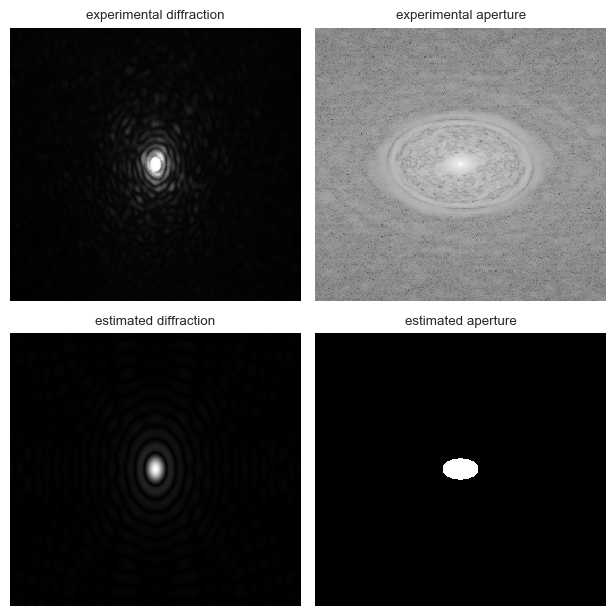

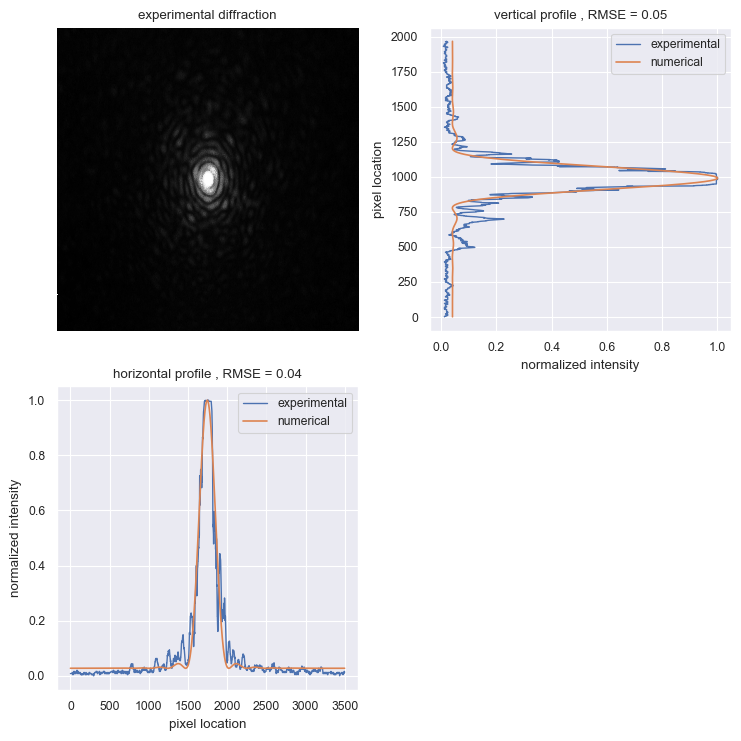

In [245]:
files = ['single-0.08.png',
         'single-0.16.png',
         'double-0.04-0.25.png',
         'double-0.08-0.25.png',
         'double-0.08-0.50.png',
         'pinhole-0.02.png']
thresh = [205, 183, 180, 165, 155, 220]
for c, (f, t) in enumerate(zip(files, thresh)):
    if c != 5: continue
    ae = ApertureEstimator(f, 'darkframe-iso800-30fps.png')
    ae.estimateAperture(logscale=True, hold='on')
    plt.close('all')
    ae.diffractionFitter(t)
    savename = ''.join(f.split('.')[:-1]) + '-estimate.png'
    ae.showFit(r=128, savename=savename)
    ptype = f.split('-')[0]
    savename = ''.join(f.split('.')[:-1]) + '-profile.png'
    ae.fitProfile(ptype, savename=savename)